# Omega Aragonite Escape Velocity (Final Script)

# Regional Velocity Distribution Comparison over Historical, Contemporary, Future Timescales

# 10 year Moving Average every 1 year

In [1]:
import xgcm
import xarray as xr
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from xhistogram.xarray import histogram
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

## Surface k11 RCP85 Ensemble Average

In [4]:
# k11 Omega Arag for ensemble average (preprocessed)

directory = '~/chazbpei2020/data/processed/Omega_Arag/RCP85/'
filename = 'omega_arag_k11_ensAvg_1950_2100.nc'
oa_path = directory+filename
ds = xr.open_dataset(oa_path).rename({'XT_OCEAN': 'xt_ocean',
                                     'YT_OCEAN': 'yt_ocean',
                                     'TIME': 'time',
                                     'OMEGA_ARAG': 'omega_arag'})

---

## Annual Mean Omega Arag

In [5]:
# Calculate the time-mean Omega Arag throughout the simulation
da_oa_annual = ds.omega_arag.groupby('time.year').mean(dim='time', skipna=True).squeeze()

startyear = 1950
endyear = 2100
interval = 10  # plot decadal contours
span = interval//2
    
da_oa_mean = da_oa_annual.copy() # annual averages from 1950-2100
# # da_oa_mean moving averages span from 1955-2095
# da_oa_mean = moving_avg(da_oa_annual, startyear, endyear, interval)

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


---

# Calculate Escape Vectors

In [6]:
# Definte projection transformations and coordiantes
crs = ccrs.Robinson(central_longitude=180)
src=ccrs.PlateCarree()
lon = ds.xt_ocean.data
lat = ds.yt_ocean.data


# Create levels array to isolate undersaturation threshold
clevs=[1]

# Create list of colors and legend for plots
colors = ['hotpink','magenta','darkviolet','purple',
          'darkblue','blue','dodgerblue','turquoise',
          'limegreen','lime','gold','darkorange',
          'orangered','red','firebrick','maroon']

num_contours = len(da_oa_mean)
num_colors = len(colors)
year=startyear  # start in 1950
legend_years = []
c = 0
for i in range(0, num_contours, interval):
    element = Patch(facecolor=colors[c], label=str(year))
    legend_years.append(element)
    year+=interval
    c+=1

## Plot undersaturation borders

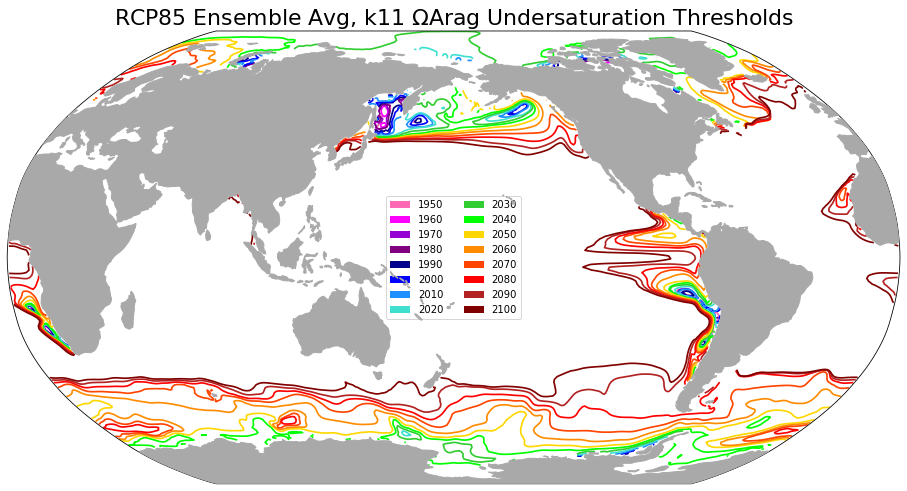

In [7]:
# Plot Velocities at undersaturation border for every 2 years
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})
    
# Plot contours for each decade
c = 0
for i in range(0, num_contours, interval):
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[c],linewidths=1.7,transform=src)
    c += 1
    
ax.legend(handles=legend_years, loc='center',ncol=2)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.set_title('RCP85 Ensemble Avg, k11 $\Omega$Arag Undersaturation Thresholds',
             fontsize=22)
ax.set_global()

fig.savefig('./oa_escvel_figs/RCP85/oa_k11_esc_contours')

## Get points along contours

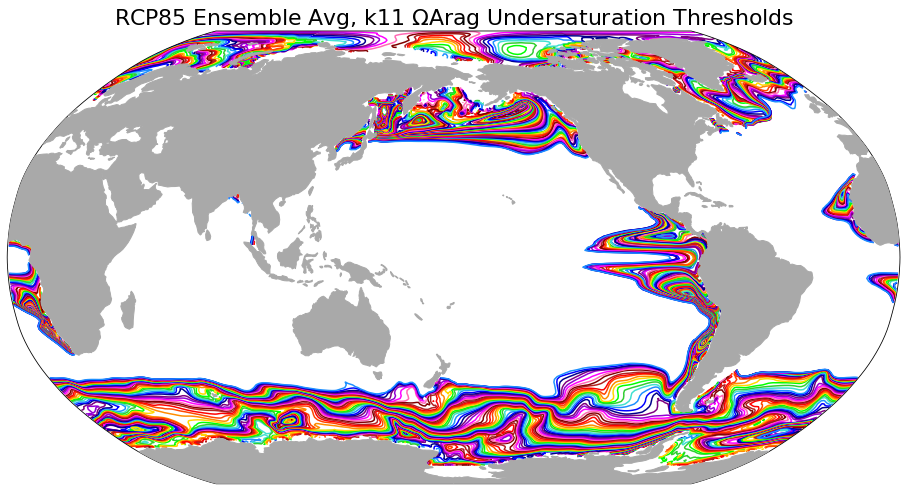

In [8]:
# Calculate Velocities at undersaturation border for every 2 years
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})
    
# Extract points from contour line segments for each year
list_xpoints = []  # list contianing lists of x points for each year
list_ypoints = []  # list contianing lists of y points for each year
for i in range(0, num_contours):
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[i%num_colors],transform=src)
    
    segments = cs.allsegs[0]
    num_segs = len(segments)
    
    xpoints = []  # to track multiple paths within each year
    ypoints = []
    for j in range(num_segs):
        x = segments[j][:,0].tolist()  # convert to list to be easily concatenated
        y = segments[j][:,1].tolist()
        for p in x:
            xpoints.append(p)
        for p in y:
            ypoints.append(p)
    list_xpoints.append(xpoints)  # add list of x points for each year
    list_ypoints.append(ypoints)  # add list of y points for each year

ax.set_title('RCP85 Ensemble Avg, k11 $\Omega$Arag Undersaturation Thresholds',
             fontsize=22)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.set_global()

## Calculations

In [9]:
# Round all values to nearest 0.5 (to be easily indexed)
# Create adjusted list to use later for indexing
list_xpoints_idx = []
list_ypoints_idx = []
for i in range(num_contours):  # list of lists
    xpoints_approx = list_xpoints[i].copy()  # individual list of xpoints
    ypoints_approx = list_ypoints[i].copy()  # individual list of ypoints
    num_points = len(xpoints_approx)
    for p in range(num_points):
        xpoints_approx[p] = round_half(xpoints_approx[p])
        ypoints_approx[p] = round_half(ypoints_approx[p])
    xpoints_approx = (np.array(xpoints_approx)-0.5).tolist()
    ypoints_approx = (np.array(ypoints_approx)+89.5).tolist()
    
    list_xpoints_idx.append(xpoints_approx)
    list_ypoints_idx.append(ypoints_approx)

In [10]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

In [11]:
# %%time
# # For each contour, compute the minimum distance to the contour at
# # the end of the interval
# # Create parallel arrays of list to hold lists of directions and vectors for each decade
# # list_nearest_x = []  # nearest x points
# # list_nearest_y = []  # nearest y points
# list_vector_dx = []  # change in x
# list_vector_dy = []  # change in y
# list_vector_magnitude = []  # distance to nearest points

# for i in range(0, num_contours-interval):
# #     nearest_x = []
# #     nearest_y = []
#     vector_dx = []  # change in x for decade
#     vector_dy = []  # change in y for decade
#     vector_magnitude = []  # vector magnitude for year
#     xpoints = list_xpoints[i]  # x coords for year
#     ypoints = list_ypoints[i]  # y coords for year
#     # For each point, find min dist and closest point on contour 
#     # at the end of the time interval (one decade later)
#     num_points = len(xpoints)
#     for p in range(num_points):
#         xp = xpoints[p] # x value along contour
#         yp = ypoints[p] # y value along contour
#         x,y,dx,dy,mindist = min_dist(xp,yp,
#                                      list_xpoints[i+interval],
#                                      list_ypoints[i+interval],
#                                     da_oa_mean[i].data)
#         # maintain lists of x and y vectors
# #         nearest_x.append(x)
# #         nearest_y.append(y)
#         vector_dx.append(dx/1000)
#         vector_dy.append(dy/1000)
#         vector_magnitude.append(mindist/1000)  # dist magnitude
        
# #     list_nearest_x.append(nearest_x)
# #     list_nearest_y.append(nearest_y)
#     list_vector_dx.append(vector_dx)
#     list_vector_dy.append(vector_dy)
#     list_vector_magnitude.append(vector_magnitude)

---

---

## Read and parse DataArray

In [12]:
ens_name = 'ensAvg'
da_velocity = xr.open_dataset('./oa_ensemble_escvel/ens_values/'+ens_name)
da_xpoints = xr.open_dataset('./oa_ensemble_escvel/ens_xcoords/'+ens_name)
da_ypoints = xr.open_dataset('./oa_ensemble_escvel/ens_ycoords/'+ens_name)

In [13]:
list_escvel_cleaned = []
list_xpoints_cleaned = []
list_ypoints_cleaned = []
max_len = len(da_velocity.val_idx)
vel_data_range = 141
for i in range(0, vel_data_range):
    escvel = da_velocity.isel(year=i).velocity.data.tolist()
    xpoints = da_xpoints.isel(year=i).xpoints.data.tolist()
    ypoints = da_ypoints.isel(year=i).ypoints.data.tolist()
    
    nan_idx = None
    for p in range(0,max_len):
        val = escvel[p]
        if val != val:
            nan_idx = p  # track index where filler NaN values start
            break
            
    del escvel[p:]
    del xpoints[p:]
    del ypoints[p:]
            
    list_escvel_cleaned.append(escvel)
    list_xpoints_cleaned.append(xpoints)
    list_ypoints_cleaned.append(ypoints)

In [14]:
# Round all values to nearest 0.5 (to be easily indexed)
# Create adjusted list to use later for indexing
list_xpoints_idx = []
list_ypoints_idx = []
for i in range(vel_data_range):  # list of lists
    xpoints_approx = list_xpoints_cleaned[i].copy()  # individual list of xpoints
    ypoints_approx = list_ypoints_cleaned[i].copy()  # individual list of ypoints
    num_points = len(xpoints_approx)
    for p in range(num_points):
        xpoints_approx[p] = round_half(xpoints_approx[p])
        ypoints_approx[p] = round_half(ypoints_approx[p])
    xpoints_approx = (np.array(xpoints_approx)-0.5).tolist()
    ypoints_approx = (np.array(ypoints_approx)+89.5).tolist()
    
    list_xpoints_idx.append(xpoints_approx)
    list_ypoints_idx.append(ypoints_approx)

---

In [59]:
# Reformat data to be Mappable
nx = len(lon)
ny = len(lat)
# da_esc_dx = []  # escape dx for each year
# da_esc_dy = []  # escape dy for each year
# da_esc_dist = []  # escape distances for each year
list_escvel_map = []

# For each year
for i in range(0,num_contours-interval):
    # Create empty arrays and initialize all values to np.nan
#     da_dx = np.zeros(shape=(nx,ny))
#     da_dx[:,:] = np.nan
#     da_dy = np.zeros(shape=(nx,ny))
#     da_dy[:,:] = np.nan
#     da_dist = np.zeros(shape=(nx,ny))
#     da_dist[:,:] = np.nan
    da_escvel_map = np.zeros(shape=(nx,ny))
    da_escvel_map[:,:] = np.nan
    
    
    # Iterate through points in array of contour point indices
    x_idx = list_xpoints_idx[i]
    y_idx = list_ypoints_idx[i]
#     dx_vals = list_vector_dx[i]
#     dy_vals = list_vector_dy[i]
#     dist_vals = list_vector_magnitude[i]
    escvel_vals = list_escvel_cleaned[i]
    
    # For each contour point in the decade, save the escape vector
    # magnitude and direction in parallel DataArrays
    num_points = len(x_idx)
    for p in range(num_points):
        xi = int(x_idx[p])
        yi = int(y_idx[p])
#         da_dx[xi,yi] = dx_vals[p]
#         da_dy[xi,yi] = dy_vals[p]
#         da_dist[xi,yi] = dist_vals[p]
        da_escvel_map[xi,yi] = escvel_vals[p]
    
    # Save out the vector (directionality and magnitude) fields as maps 
    # for each year
#     da_dx = xr.DataArray(da_dx, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
#     da_dx = da_dx.where(da_dx < np.inf)
#     da_esc_dx.append(da_dx)
#     da_dy = xr.DataArray(da_dy, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
#     da_dy = da_dy.where(da_dy < np.inf)
#     da_esc_dy.append(da_dy)
#     da_dist = xr.DataArray(da_dist, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
#     da_dist = da_dist.where(da_dist < np.inf)
#     da_esc_dist.append(da_dist)
    da_escvel_map = xr.DataArray(da_escvel_map, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_escvel_map = da_escvel_map.where(da_escvel_map < np.inf)
    list_escvel_map.append(da_escvel_map)

## Plot Escape Vectors

In [16]:
# # Map escape vectors for all timestamps
# crs = ccrs.Robinson(central_longitude=180)
# fig, ax = plt.subplots(figsize=[16,8],
#                                subplot_kw={'projection':crs})

# # Create meshgrid for arrow plotting
# X,Y = np.meshgrid(np.arange(360), np.arange(-90,90))
# X = X+0.5
# Y = Y+0.5
# n=5

# # Plot Omega Arag undersaturation contours for each decade
# c=0
# vel_data_range = num_contours-interval
# # From 1950-2090
# for i in range(0, vel_data_range, interval):
#     cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
#                     colors=colors[c%num_colors],transform=src)
#     c+=1
    
#     # Plot escape vectors
#     U = da_esc_dx[i].data
#     V = da_esc_dy[i].data
    
#     ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n], transform=src)

# # Plot final decade contour
# cs = ax.contour(lon,lat,da_oa_mean[num_contours-1],levels=clevs,
#                     colors=colors[c],transform=src)
# ax.legend(handles=legend_years, loc='center',ncol=2)
# ax.set_title('RCP85 Ensemble Avg, k11 $\Omega$ Arag Escape Vectors',
#              fontsize=22)
# ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
# ax.set_global()

# fig.savefig('./oa_escvel_figs/RCP85/oa_k11_esc_vectors')

---

# Calculate Escape Velocity

In [60]:
# Calculate escape velocity and create DataArray
year=startyear
da_esc_vel = []
vel_data_range = num_contours-interval
# for i in range(vel_data_range):
#     da_vel = (da_esc_dist[i]).copy().rename('Escape Velocity - '+str(year))
#     da_esc_vel.append(da_vel)
#     year+=1

for i in range(vel_data_range):
    da_vel = (list_escvel_map[i]).copy().rename('Escape Velocity - '+str(year))
    da_esc_vel.append(da_vel)
    year+=1

# Escape Velocity with Corresponding Dot Sizes

In [61]:
# Transpose indices to match coordinates
list_xcoords = []
list_ycoords = []
list_escvel = []
# From years 1950 to 2090
for i in range(0,vel_data_range):
    xpoints = np.array(list_xpoints_idx[i])+0.5
    ypoints = np.array(list_ypoints_idx[i])-89.5
    escvel = np.array(list_escvel_cleaned[i])*0.2
#     escvel = np.array(list_vector_magnitude[i])*0.2
    list_xcoords.append(xpoints)
    list_ycoords.append(ypoints)
    list_escvel.append(escvel)

## Global and Regional Plots

## Global

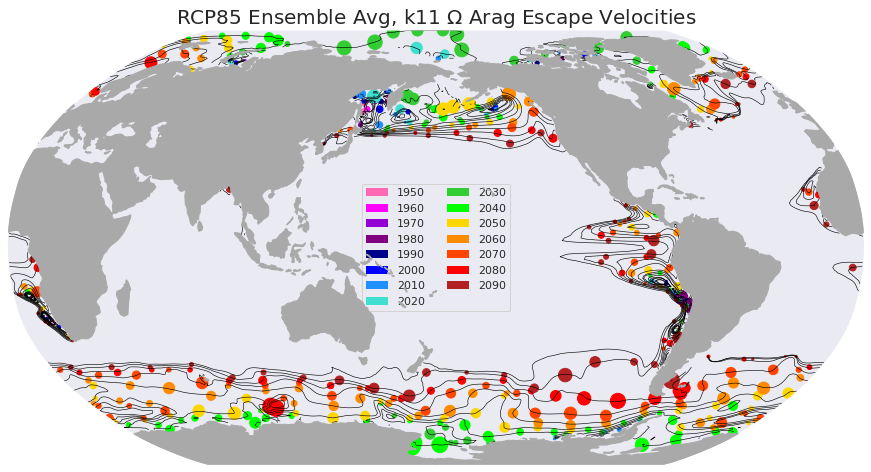

In [62]:
# Map escape velocity magnitudes for each decade
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,8],
                               subplot_kw={'projection':crs})

n = 20  # plot every n points
lwidth = 0.6  # line width

# Decadal contours up to interval before end of simulation
c=0
for i in range(0, vel_data_range, interval):
    # Plot Omega Arag undersaturation contours for each decade
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)
    
    # Plot dots with escape velocity magnitude
    ax.scatter(list_xcoords[i][::n], list_ycoords[i][::n],
               s=list_escvel[i][::n],
               color=colors[c],transform=src)
    c+=1
    
# Plot final decade contour 
cs = ax.contour(lon,lat,da_oa_mean[num_contours-1],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)

ax.legend(handles=legend_years[:-1], loc='center',ncol=2)
ax.set_title('RCP85 Ensemble Avg, k11 $\Omega$ Arag Escape Velocities',
             fontsize=20)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
ax.set_global()
# ax.gridlines()
fig.savefig('./oa_escvel_figs/RCP85/oa_k11_esc_dots')

## Central and South American Coast

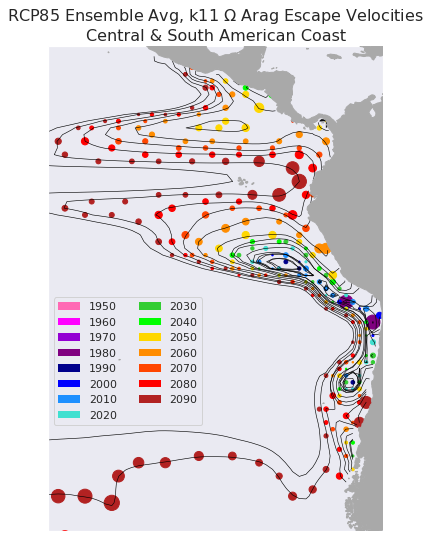

In [63]:
# Map escape velocity magnitudes Central and South America
fig, ax = plt.subplots(figsize=[6,9],
                               subplot_kw={'projection':src})

n = 5  # plot every n points

# Decadal contours up to interval before end of simulation
c=0
for i in range(0, vel_data_range, interval):
    # Plot Omega Arag undersaturation contours for each decade
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)
    
    # Plot dots with escape velocity magnitude
    ax.scatter(list_xcoords[i][::n], list_ycoords[i][::n],
               s=list_escvel[i][::n],
               color=colors[c],transform=src)
    c+=1
    
# Plot final decade contour 
cs = ax.contour(lon,lat,da_oa_mean[num_contours-1],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)

ax.legend(handles=legend_years[:-1], loc='center left',bbox_to_anchor=(0,0.35),ncol=2)
ax.set_title('RCP85 Ensemble Avg, k11 $\Omega$ Arag Escape Velocities\nCentral & South American Coast',
             fontsize=16)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
extents = [-120,-70,-50,18]  # [x0,x1,y0,y1]
ax.set_extent(extents)

fig.savefig('./oa_escvel_figs/RCP85/oa_k11_esc_dots_america')

## African Coast

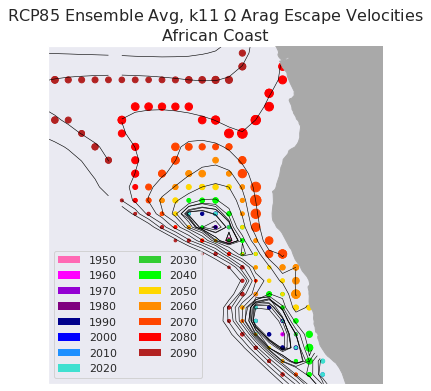

In [64]:
# Map escape velocity magnitudes for African Coast
fig, ax = plt.subplots(figsize=[6,9],
                               subplot_kw={'projection':src})

n = 1  # plot every n points

# Decadal contours up to interval before end of simulation
c=0
for i in range(0, vel_data_range, interval):
    # Plot Omega Arag undersaturation contours for each decade
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)

    # Plot dots with escape velocity magnitude
    ax.scatter(list_xcoords[i][::n], list_ycoords[i][::n],
               s=list_escvel[i][::n],
               color=colors[c],transform=src)
    c+=1
    
# Plot final decade contour 
cs = ax.contour(lon,lat,da_oa_mean[num_contours-1],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)

ax.legend(handles=legend_years[:-1], loc='lower left',ncol=2)
ax.set_title('RCP85 Ensemble Avg, k11 $\Omega$ Arag Escape Velocities\nAfrican Coast',
             fontsize=16)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
extents = [-5,20,-30,-5]  # [x0,x1,y0,y1]
ax.set_extent(extents)
fig.savefig('./oa_escvel_figs/RCP85/oa_k11_esc_dots_africa')

## Northern Pacific Ocean

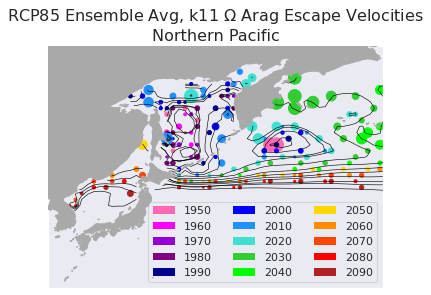

In [65]:
# Map escape velocity magnitudes for Northern Pacific
fig, ax = plt.subplots(figsize=[6,9],
                               subplot_kw={'projection':src})

n = 5  # step size when iterating

# Decadal contours up to interval before end of simulation
c=0
for i in range(0, vel_data_range, interval):
    # Plot Omega Arag undersaturation contours for each decade
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)
    
    # Plot dots with escape velocity magnitude
    ax.scatter(list_xcoords[i][::n], list_ycoords[i][::n],
               s=list_escvel[i][::n],
               color=colors[c],transform=src)
    c+=1
    
# Plot final decade contour 
cs = ax.contour(lon,lat,da_oa_mean[num_contours-1],levels=clevs,
                    colors='black',linewidths=lwidth,transform=src)

ax.legend(handles=legend_years[:-1], loc='lower right',ncol=3)
ax.set_title('RCP85 Ensemble Avg, k11 $\Omega$ Arag Escape Velocities\nNorthern Pacific',
             fontsize=16)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
extents = [125,180,25,62]  # [x0,x1,y0,y1]
ax.set_extent(extents)
fig.savefig('./oa_escvel_figs/RCP85/oa_k11_esc_dots_northpacific')

___

# Escape Velocity Distribution Plots:

___

## Clean and Parse Data

In [66]:
ens_name = 'ensAvg1yr'
directory = './oa_ensemble_escvel/ens_values/'
filename = ens_name
vel_path = directory+filename
da_velocity = xr.open_dataset(vel_path)

In [67]:
cleaned_escvel = []
max_len = len(da_velocity.val_idx)
vel_data_range = 141
for i in range(0, vel_data_range):
    escvel = da_velocity.isel(year=i).velocity.data.tolist()
    nan_idx = None
    for p in range(0,max_len):
        val = escvel[p]
        if val != val:
            nan_idx = p  # track index where filler NaN values start
            break
            
    del escvel[p:]
            
    cleaned_escvel.append(escvel)

___

## Define histogram bin sizes

In [68]:
# Define bin range and interval size
xlim = 1001  # use (top value)+1 to ease indexing
vstep = 50
vlevels = np.arange(0, xlim, vstep)
# vlevels = [0, 50, 100, 250, 500, 1000]
vbins = np.array(vlevels)

## Annual Velocity Distributions

In [69]:
# Get escape velocity distributions for each year
list_vel_distr = []  # global escape velocity distributions for each year
for i in range(vel_data_range):
    h = histogram(xr.DataArray(cleaned_escvel[i]).rename("Escape Velocity"), bins=[vbins]).data
#     h = histogram(da_esc_vel[i].rename('Escape Velocity'), bins=[vbins]).data
#     h = histogram(da_escvel_map[i], bins=[vbins]).data
    h = h / h.sum()
    h = xr.DataArray(h,dims=['bin_edges'],
                     coords=[np.delete(vbins,len(vbins)-1)]).rename('filler')
    list_vel_distr.append(h)

In [70]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

## Colormap, Legend, Style

In [71]:
# Create discrete color map and legend
clrs = mpl.cm.viridis(np.linspace(0,1,15))
num_clrs = len(clrs)
list_clrs = []
for i in range(0,num_clrs):
    list_clrs.append(tuple(clrs[i]))


year=startyear  # start in 1950
legend_yrs = []
c = 0
for i in range(0, vel_data_range, interval):
    element = Patch(facecolor=clrs[c], label=str(year))
    legend_yrs.append(element)
    year+=interval
    c+=1
    
# Set context of plots
sns.set()  # context = {notebook, paper, talk, poster}
# sns.set_context(context=None)
# sns.set_style('white')
# sns.reset_orig()  # revert to matplotlib presets

## Decadal Distribution

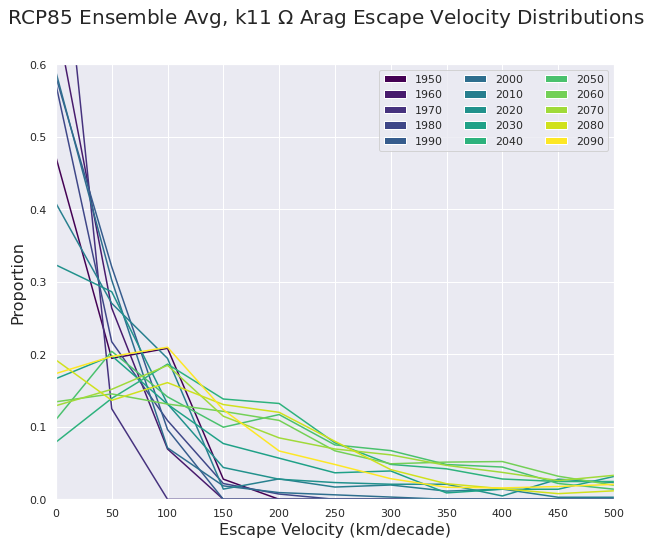

In [72]:
# Create Histograms for escape velocity distribution at each timestep
fig, ax = plt.subplots(figsize=[10,8])

year = 1950
t = year-1950
c=0
for i in range(0, vel_data_range, interval):

#     h = histogram(da_esc_vel[i], bins=[vbins])
#     h = h / h.sum();
#     h.plot(ax=ax,color=clrs[c])

    list_vel_distr[i].plot(ax=ax,color=clrs[c])
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_xlim(0,500)
    ax.set_xticks(vlevels[:-10])
    ax.set_ylabel('Proportion',fontsize=16)
    ax.set_ylim(0,0.6)
    ax.legend(handles=legend_yrs, loc='upper right',ncol=3)

    ax.label_outer()
    year+=10
    t+=10
    c+=1

fig.suptitle('RCP85 Ensemble Avg, k11 $\Omega$ Arag Escape Velocity Distributions',
            fontsize=20)
fig.savefig("./oa_escvel_stats/oa_k11_escvel_distrib_1plot")

## Decadal Density

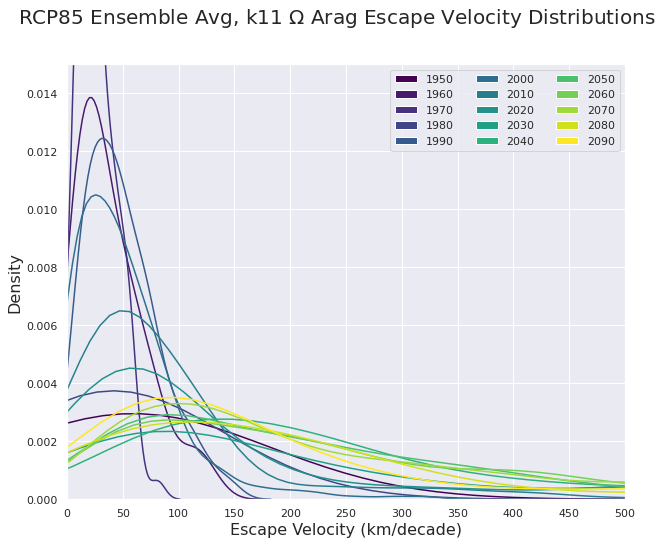

In [73]:
# Create Histograms for escape velocity distribution at each timestep
fig, ax = plt.subplots(figsize=[10,8])

year = 1950
t = year-1950
c=0
for i in range(0, vel_data_range, interval):
    # make masks of 0 and 1 --> multiply
    escvel_vals = xr.DataArray(cleaned_escvel[i]).rename('filler')
    sns.distplot(escvel_vals, ax=ax, bins=vbins, color=list_clrs[c], 
                 hist=False,norm_hist=True)   # needs a color name

    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_xlim(0,500)
    ax.set_xticks(vlevels[:-10])
    ax.set_ylabel('Density',fontsize=16)
    ax.set_ylim(0,0.015)
    ax.legend(handles=legend_yrs, loc='upper right',ncol=3)

    ax.label_outer()
    year+=10
    t+=10
    c+=1

fig.suptitle('RCP85 Ensemble Avg, k11 $\Omega$ Arag Escape Velocity Distributions',
            fontsize=20)
fig.savefig("./oa_escvel_stats/oa_k11_escvel_density_1plot")

---

## Differentiate Larger Regions (***Differentiate more regions for latitudinal distribution plots)

In [74]:
da_escvel_north = []  # Northern Ocean
da_escvel_equ = []  # Equatorial region
da_escvel_south = []  # Southern ocean
for i in range(vel_data_range):
    da_escvel_north.append(da_esc_vel[i].loc[35:80,:].copy())  # don't use 80N and above
    da_escvel_equ.append(da_esc_vel[i].loc[-40:35,:].copy())
    da_escvel_south.append(da_esc_vel[i].loc[-90:-40,:].copy())

## Differentiate Historic, Contemporary, Future Time Periods

In [75]:
# Calculate average Escape Velocity distributions for each region
# during each time period
contemp = 50
future = 100
end = vel_data_range

# da_escvel_north
north_historic_mean = hist_mean(da_escvel_north, vlevels, 0, contemp, 'north_historic')
north_contemp_mean = hist_mean(da_escvel_north, vlevels, contemp, future, 'north_contemp')
north_future_mean = hist_mean(da_escvel_north, vlevels, future, end, 'north_future')

# da_escvel_equ
equ_historic_mean = hist_mean(da_escvel_equ, vlevels, 0, contemp, 'equ_historic')
equ_contemp_mean = hist_mean(da_escvel_equ, vlevels, contemp, future, 'equ_contemp')
equ_future_mean = hist_mean(da_escvel_equ, vlevels, future, end, 'equ_future')

# da_escvel_south
south_historic_mean = hist_mean(da_escvel_south, vlevels, 0, contemp, 'south_historic')
south_contemp_mean = hist_mean(da_escvel_south, vlevels, contemp, future, 'south_contemp')
south_future_mean = hist_mean(da_escvel_south, vlevels, future, end, 'south_future')

# da_esc_vel
global_historic_mean = hist_mean(da_esc_vel, vlevels, 0, contemp, 'global_historic')
global_contemp_mean = hist_mean(da_esc_vel, vlevels, contemp, future, 'global_contemp')
global_future_mean = hist_mean(da_esc_vel, vlevels, future, end, 'global_future')

In [76]:
# Define legend and colormap
colorcmp = ['plum','darkviolet','indigo',
            'moccasin','darkorange','orangered',
            'lawngreen','limegreen','green',
           'lightskyblue','dodgerblue','blue']
# Northern --> [35:80]
# Equatorial --> [-40:35]
# Global --> [-90:-40]
regions = ['Northern (Historical)','Northern (Contemporary)','Northern (Future)',
           'Equatorial (Historical)','Equatorial (Contemporary)','Equatorial (Future)',
          'Southern (Historical)','Southern (Contemporary)','Southern (Future)',
          'Global (Historical)','Global (Contemporary)','Global (Future)']
legend_regions = []
num_cmap = len(colorcmp)
for i in range(num_cmap):
    element = Patch(facecolor=colorcmp[i], label=regions[i])
    legend_regions.append(element)

## Regional Plots

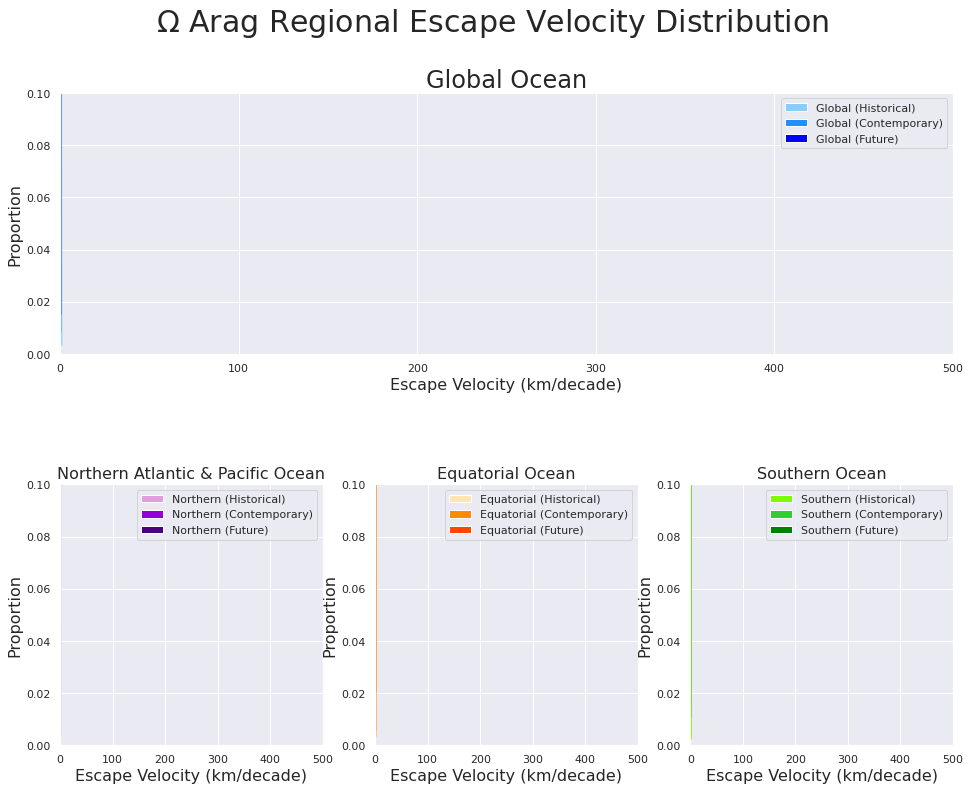

In [77]:
# Probably won't work
# Create Histograms for Different Regions' Escape Velocities
fig, ax = plt.subplots(figsize=[16,12])
ax.remove()

gs=mpl.gridspec.GridSpec(nrows=2,ncols=3,hspace=0.5) # 2 rows, 3 columns
axs = []
axs.append(fig.add_subplot(gs[1,0])) # Second row, first column
axs.append(fig.add_subplot(gs[1,1])) # Second row, second column
axs.append(fig.add_subplot(gs[1,2])) # Second row, third column
axs.append(fig.add_subplot(gs[0,:])) # First row, span all columns

c=0
# Northern Ocean
ax = axs[0]
sns.distplot(north_historic_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
sns.distplot(north_contemp_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
sns.distplot(north_future_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
ax.set_title('Northern Atlantic & Pacific Ocean',fontsize=16)

# Equatorial Ocean
ax = axs[1]
sns.distplot(equ_historic_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
sns.distplot(equ_contemp_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
sns.distplot(equ_future_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
ax.set_title('Equatorial Ocean',fontsize=16)

# Southern Ocean
ax = axs[2]
sns.distplot(south_historic_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
sns.distplot(south_contemp_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
sns.distplot(south_future_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
ax.set_title('Southern Ocean',fontsize=16)

# # Global Ocean
ax = axs[3]
sns.distplot(global_historic_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
sns.distplot(global_contemp_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
sns.distplot(global_future_mean, ax=ax, bins=vbins, color=colorcmp[c], hist=False,norm_hist=True); c+=1  # needs a color name
ax.set_title('Global Ocean',fontsize=24)

i=0
for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_ylim(0,0.1)
    ax.set_xlim(0,500)
    ax.legend(handles=legend_regions[i:i+3], loc='upper right')
    i+=3
    
fig.suptitle('$\Omega$ Arag Regional Escape Velocity Distribution',
                fontsize=30)

fig.savefig("./oa_escvel_stats/oa_k11_escvel_regional_density")

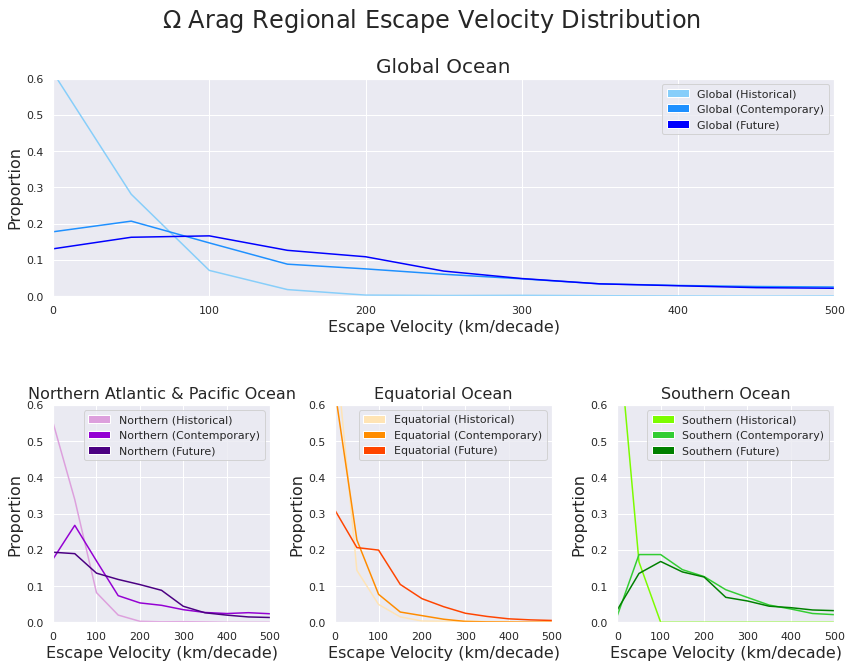

In [78]:
# Create Histograms for Different Regions' Escape Velocities
fig, ax = plt.subplots(figsize=[14,10])
ax.remove()

gs=mpl.gridspec.GridSpec(nrows=2,ncols=3,hspace=0.5,wspace=0.3) # 2 rows, 3 columns
axs = []
axs.append(fig.add_subplot(gs[1,0])) # Second row, first column
axs.append(fig.add_subplot(gs[1,1])) # Second row, second column
axs.append(fig.add_subplot(gs[1,2])) # Second row, third column
axs.append(fig.add_subplot(gs[0,:])) # First row, span all columns

# Global Ocean
ax = axs[3]
global_historic_mean.plot(ax=ax,color=colorcmp[9])
global_contemp_mean.plot(ax=ax,color=colorcmp[10])
global_future_mean.plot(ax=ax,color=colorcmp[11])
ax.set_title('Global Ocean',fontsize=20)

# Northern Ocean
ax = axs[0] 
north_historic_mean.plot(ax=ax,color=colorcmp[0])
north_contemp_mean.plot(ax=ax,color=colorcmp[1])
north_future_mean.plot(ax=ax,color=colorcmp[2])
ax.set_title('Northern Atlantic & Pacific Ocean',fontsize=16)

# Equatorial Ocean
ax = axs[1]
equ_historic_mean.plot(ax=ax,color=colorcmp[3])
equ_contemp_mean.plot(ax=ax,color=colorcmp[4])
equ_future_mean.plot(ax=ax,color=colorcmp[5])
ax.set_title('Equatorial Ocean',fontsize=16)

# Southern Ocean
ax = axs[2]
south_historic_mean.plot(ax=ax,color=colorcmp[6])
south_contemp_mean.plot(ax=ax,color=colorcmp[7])
south_future_mean.plot(ax=ax,color=colorcmp[8])
ax.set_title('Southern Ocean',fontsize=16)

i=0
for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_ylim(0,0.6)
    ax.set_xlim(0,500)
    ax.legend(handles=legend_regions[i:i+3], loc='upper right')
    i+=3
    
fig.suptitle('$\Omega$ Arag Regional Escape Velocity Distribution',
                fontsize=24)

fig.savefig("./oa_escvel_stats/oa_k11_escvel_regional_distr")

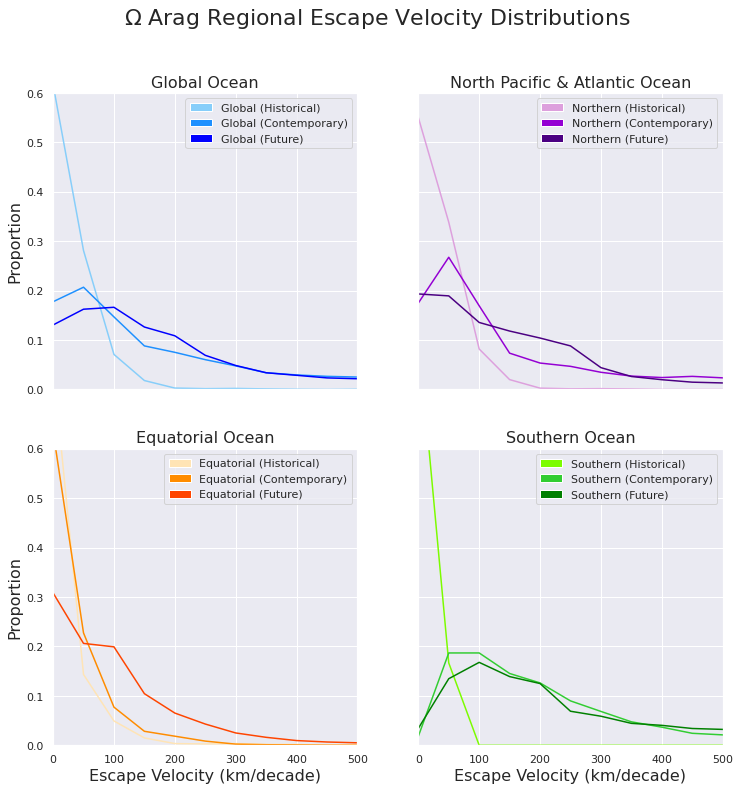

In [79]:
# Create Histograms for Different Regions' Escape Velocities
nrows=2
ncols=2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12,12], 
                        sharex=True,sharey=True)

# Global
ax = axs[0,0]
global_historic_mean.plot(ax=ax,color=colorcmp[9])
global_contemp_mean.plot(ax=ax,color=colorcmp[10])
global_future_mean.plot(ax=ax,color=colorcmp[11])
ax.set_title('Global Ocean',fontsize=16)

# Northern
ax = axs[0,1]
north_historic_mean.plot(ax=ax,color=colorcmp[0])
north_contemp_mean.plot(ax=ax,color=colorcmp[1])
north_future_mean.plot(ax=ax,color=colorcmp[2])
ax.set_title('North Pacific & Atlantic Ocean',fontsize=16)

# Equatorial
ax = axs[1,0]
equ_historic_mean.plot(ax=ax,color=colorcmp[3])
equ_contemp_mean.plot(ax=ax,color=colorcmp[4])
equ_future_mean.plot(ax=ax,color=colorcmp[5])
ax.set_title('Equatorial Ocean',fontsize=16)

# Southern
ax = axs[1,1]
south_historic_mean.plot(ax=ax,color=colorcmp[6])
south_contemp_mean.plot(ax=ax,color=colorcmp[7])
south_future_mean.plot(ax=ax,color=colorcmp[8])
ax.set_title('Southern Ocean',fontsize=16)

i=9
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row,col]
        ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
        ax.set_ylabel('Proportion',fontsize=16)
        ax.set_ylim(0,0.6)
        ax.set_xlim(0,500)
        ax.label_outer()
        ax.legend(handles=legend_regions[i:i+3], loc='upper right')
        i = (i+3)%12
    
fig.suptitle('$\Omega$ Arag Regional Escape Velocity Distributions',
                fontsize=22)

fig.savefig("./oa_escvel_stats/oa_k11_escvel_regional_distr_2x2")

___

## Differentiate Latitude Slices

In [80]:
# Differentiate latitude levels (10 degree slices)
num_slices = 18
list_escvel_slices = []

da_escvel_80_90_N = []
da_escvel_70_80_N = []
da_escvel_60_70_N = []
da_escvel_50_60_N = []
da_escvel_40_50_N = []
da_escvel_30_40_N = []
da_escvel_20_30_N = []
da_escvel_10_20_N = []
da_escvel_00_10_N = []
da_escvel_10_00_S = []
da_escvel_20_10_S = []
da_escvel_30_20_S = []
da_escvel_40_30_S = []
da_escvel_50_40_S = []
da_escvel_60_50_S = []
da_escvel_70_60_S = []
da_escvel_80_70_S = []
da_escvel_90_80_S = []

for i in range(0,vel_data_range):
    da_escvel_80_90_N.append(da_esc_vel[i].loc[80:90,:].copy())
    da_escvel_70_80_N.append(da_esc_vel[i].loc[70:80,:].copy())
    da_escvel_60_70_N.append(da_esc_vel[i].loc[60:70,:].copy())
    da_escvel_50_60_N.append(da_esc_vel[i].loc[50:60,:].copy())
    da_escvel_40_50_N.append(da_esc_vel[i].loc[40:50,:].copy())
    da_escvel_30_40_N.append(da_esc_vel[i].loc[30:40,:].copy())
    da_escvel_20_30_N.append(da_esc_vel[i].loc[20:30,:].copy())
    da_escvel_10_20_N.append(da_esc_vel[i].loc[10:20,:].copy())
    da_escvel_00_10_N.append(da_esc_vel[i].loc[0:10, :].copy())
    da_escvel_10_00_S.append(da_esc_vel[i].loc[-10:0,:].copy())
    da_escvel_20_10_S.append(da_esc_vel[i].loc[-20:-10,:].copy())
    da_escvel_30_20_S.append(da_esc_vel[i].loc[-30:-20,:].copy())
    da_escvel_40_30_S.append(da_esc_vel[i].loc[-40:-30,:].copy())
    da_escvel_50_40_S.append(da_esc_vel[i].loc[-50:-40,:].copy())
    da_escvel_60_50_S.append(da_esc_vel[i].loc[-60:-50,:].copy())
    da_escvel_70_60_S.append(da_esc_vel[i].loc[-70:-60,:].copy())
    da_escvel_80_70_S.append(da_esc_vel[i].loc[-80:-70,:].copy())
    da_escvel_90_80_S.append(da_esc_vel[i].loc[-90:-80,:].copy())
    
list_escvel_slices.append(da_escvel_80_90_N)
list_escvel_slices.append(da_escvel_70_80_N)
list_escvel_slices.append(da_escvel_60_70_N)
list_escvel_slices.append(da_escvel_50_60_N)
list_escvel_slices.append(da_escvel_40_50_N)
list_escvel_slices.append(da_escvel_30_40_N)
list_escvel_slices.append(da_escvel_20_30_N)
list_escvel_slices.append(da_escvel_10_20_N)
list_escvel_slices.append(da_escvel_00_10_N)
list_escvel_slices.append(da_escvel_10_00_S)
list_escvel_slices.append(da_escvel_20_10_S)
list_escvel_slices.append(da_escvel_30_20_S)
list_escvel_slices.append(da_escvel_40_30_S)
list_escvel_slices.append(da_escvel_50_40_S)
list_escvel_slices.append(da_escvel_60_50_S)
list_escvel_slices.append(da_escvel_70_60_S)
list_escvel_slices.append(da_escvel_80_70_S)
list_escvel_slices.append(da_escvel_90_80_S)

In [81]:
# Define new bin size if necessary
vstep1 = 25
vlevels1 = np.arange(0, xlim, vstep1)
# vlevels = [0, 50, 100, 250, 500, 1000]
vbins1 = np.array(vlevels1)
num_bins = len(vbins1)-1

In [92]:
# Make colormap and latitude coordinate arrays
y_clrs = mpl.cm.viridis(np.linspace(0,1,12))
num_y_clrs = 9
list_y_clrs = []
for i in range(0,num_y_clrs):
    list_y_clrs.append(tuple(y_clrs[i]))
for i in range(0,num_y_clrs):
    list_y_clrs.append(tuple(y_clrs[num_y_clrs-1-i]))

lat = -85 
list_lat = []
for s in range(num_slices):
    yt_ocean = np.full(num_bins,lat).squeeze()
    list_lat.append(yt_ocean)
    lat+=10

In [93]:
# Get escape velocity distributions for each year
list_lat_distr = []  # annual latitudinal escape velocity distributions for each slice

for s in range(num_slices):
    da_escvel_slice = list_escvel_slices[s]
    lat_distr = []
    yt_ocean = np.full(18,lat)
    for i in range(vel_data_range):
        h = histogram(xr.DataArray(da_escvel_slice[i]), bins=[vbins1]).data
        h = h / h.sum()
        h = xr.DataArray(h,dims=['bin_edges'],
                         coords=[np.delete(vbins1+12.5,len(vbins1)-1)]).rename('filler')
        lat_distr.append(h)  # append annual latitudinal velocity distribution
        
    list_lat_distr.append(lat_distr)

<ipython-input-93-f359855062e0>:10: RuntimeWarning: invalid value encountered in true_divide
  h = h / h.sum()


In [89]:
# list_lat_distr[s][100]

## Escape Velocity Latitudinal Distributions

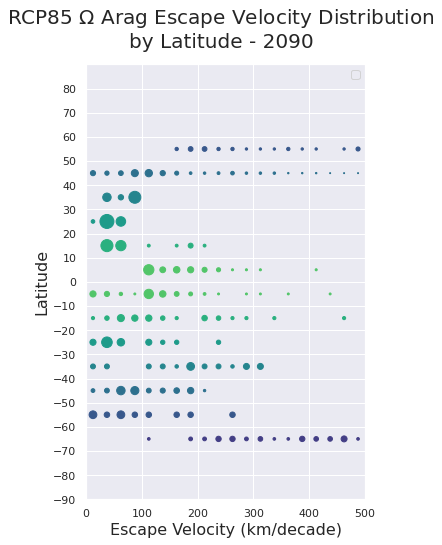

In [94]:
# Escape Velocity Map and Latitudinal Distributions
fig, ax = plt.subplots(figsize=[5,8])
year = 2090
yr_idx = year-1950

for s in range(num_slices):
    ax.scatter(list_lat_distr[s][yr_idx].bin_edges, list_lat[s],
              list_lat_distr[s][yr_idx]*300,
              color=list_y_clrs[s])
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Latitude',fontsize=16)
    ax.set_ylim(-90,90)
    ax.set_yticks(np.arange(-90,90,10))
    ax.set_xlim(0,500)
    ax.legend(handles=legend_regions[i:i+3], loc='upper right')


fig.suptitle('RCP85 $\Omega$ Arag Escape Velocity Distribution\nby Latitude - '+str(year),
                fontsize=20)

fig.savefig("./oa_escvel_stats/oa_k11_escvel_lat_distr")

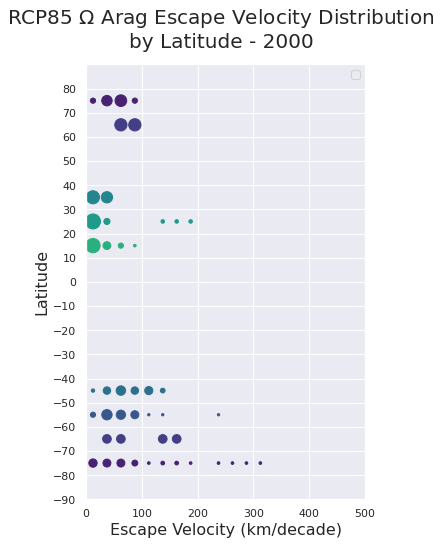

In [95]:
# Escape Velocity Map and Latitudinal Distributions
fig, ax = plt.subplots(figsize=[5,8])
year = 2000
yr_idx = year-1950

for s in range(num_slices):
    ax.scatter(list_lat_distr[s][yr_idx].bin_edges, list_lat[s],
              list_lat_distr[s][yr_idx]*300,
              color=list_y_clrs[s])
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Latitude',fontsize=16)
    ax.set_ylim(-90,90)
    ax.set_yticks(np.arange(-90,90,10))
    ax.set_xlim(0,500)
    ax.legend(handles=legend_regions[i:i+3], loc='upper right')


fig.suptitle('RCP85 $\Omega$ Arag Escape Velocity Distribution\nby Latitude - '+str(year),
                fontsize=20)

fig.savefig("./oa_escvel_stats/oa_k11_escvel_lat_distr")

---

---

---